# RANDOM FOREST sur toutes les données

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import wiener, get_window
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import glob
audio_file = ...

In [138]:
import csv
import pandas as pd
tableau = []
label = []
csv_file_path = ...

# Read the CSV file and store the lines in the tableau list
with open(csv_file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for ligne in reader:
        ligne = ligne[0].split(';')
        tableau.append(ligne[1].split(' / '))
        try :
            label.append(int(ligne[2]))
        except :
            label.append(0)

print(len(tableau))
print(label)

185
[0, 1, 1, 1, 1, 2, 2, 3, 0, 2, 1, 3, 2, 2, 1, 3, 1, 2, 3, 3, 3, 3, 3, 5, 1, 3, 3, 3, 4, 3, 5, 1, 1, 4, 2, 3, 3, 3, 2, 1, 2, 1, 0, 3, 2, 3, 0, 2, 1, 1, 1, 0, 4, 4, 1, 2, 2, 1, 3, 3, 2, 4, 2, 1, 1, 5, 2, 2, 0, 2, 4, 3, 1, 1, 1, 3, 0, 0, 1, 3, 4, 2, 2, 3, 2, 4, 2, 4, 3, 5, 0, 2, 4, 4, 1, 2, 0, 4, 0, 3, 0, 3, 4, 2, 2, 3, 3, 3, 4, 4, 3, 3, 2, 2, 1, 2, 0, 1, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 4, 2, 2, 0, 0, 1, 4, 3, 4, 3, 4, 0, 3, 1, 1, 0, 1, 0, 1, 0, 2, 2, 1, 3, 2, 0, 3, 1, 2, 2, 0, 0, 1, 1, 1, 0, 2, 2, 3, 2, 2, 2, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 0]


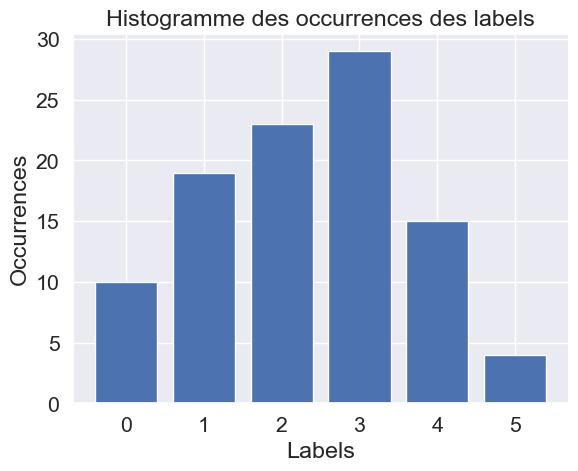

In [139]:
selection = 106
tableau = tableau[15:115]
label = label[15:115]

import matplotlib.pyplot as plt
from collections import Counter

occurrences = Counter(label)

# Récupérez les labels et les occurrences sous forme de listes
labels = list(occurrences.keys())
occurrences = list(occurrences.values())

# Créez l'histogramme
plt.bar(labels, occurrences)

# Ajoutez des labels aux axes
plt.xlabel('Labels')
plt.ylabel('Occurrences')
plt.title('Histogramme des occurrences des labels')

# Affichez l'histogramme
plt.show()

In [140]:
def est_echo(signal_original, signal_test, threshold=0.8):
    signal_original -= np.mean(signal_original)
    signal_test -= np.mean(signal_test)

    correlation_values = max(np.correlate(signal_original, - signal_test, mode='full'))
    correlation_values /= np.sqrt(np.sum(signal_original**2) * np.sum(signal_test**2))
    return np.max(signal_original) < -np.min(signal_original) and correlation_values > threshold

In [141]:
def correlation_normalized(signal1, signal2):
    correlation = np.max(np.correlate(signal1, signal2, mode='full'))
    return correlation

In [142]:
import numpy as np

def do_simple_detection_0(snr, tt, th, dt_max):
    ith = np.where(snr > th)[0]
    
    jth = ith.copy()
    jj = 0

    for ii in range(1, len(ith)):
        ki = ith[ii]
        kj = ith[jj]

        if tt[ki] - tt[kj] > dt_max:
            jj = ii
            continue
        elif snr[ki] > snr[kj]:
            jth[jj] = 0
            jj = ii
        else:
            jth[ii] = 0

    jth = jth[jth != 0]
    
    return jth, ith


def do_simple_detection_1(snr, tt, th, dt_max):
    jth, ith = do_simple_detection_0(snr, tt, th, dt_max)
    
    j1 = np.zeros_like(jth)
    j2 = np.zeros_like(jth)

    for ii in range(len(jth)):
        thc = np.where(np.abs(tt[jth[ii]] - tt[ith]) <= dt_max)[0]
        j1[ii] = min(thc)
        j2[ii] = max(thc)

    i1 = ith[j1]
    i2 = ith[j2]

    iov = np.where(i1[1:] - i2[:-1] < 0)[0]
    imx = snr[jth[iov]] > snr[jth[iov + 1]]
    iov[imx] = iov[imx] + 1

    jth = np.delete(jth, iov)
    i1 = np.delete(i1, iov)
    i2 = np.delete(i2, iov)

    return jth, i1, i2

In [143]:
import numpy as np
import matplotlib.pyplot as plt


def generer_pistes(indices, ss,fs):

    pistes = [[(indices[0])]]
    for i, (debut, fin) in enumerate(indices[1:]):
        piste_trouvee = False
        i+=1
        ICI_proche = []
        corr = []
        
        for j, piste in enumerate(pistes) :
            precedent = piste[-1]
            clic_avant = ss[int(fs*precedent[0]):int(fs*precedent[1])]
            clic_apres = ss[int(fs*debut):int(fs*fin)]
            amplitude_avant = np.max(clic_avant) - np.min(clic_avant)
            amplitude_apres = np.max(clic_apres) - np.min(clic_apres)
            delta_t = (debut - piste[-1][0])/fs

            if len(piste) > 1 :
                delta_t_1 = (piste[-1][0] - piste[-2][0])/fs
                
                if delta_t_1 * 0.7 < delta_t < delta_t_1 * 1/0.7 and amplitude_avant* 1/2 < amplitude_apres < amplitude_avant * 2 :
                    ICI_proche.append([j,abs(delta_t-delta_t_1)])

            else :
                fft_avant = np.fft.fft(clic_avant)
                fft_apres = np.fft.fft(clic_apres)
                if np.max(np.correlate(clic_avant, clic_apres,mode = 'full')) > 0.75 :
                    corr.append([j,np.max(abs(np.correlate(clic_avant, clic_apres,mode = 'full')))])

        if len(ICI_proche) > 0 :
            piste_trouvee = True
            ICI_proche = np.array(ICI_proche)
            indice_liste = int(ICI_proche[np.argmin(ICI_proche[:,1])][0])
            pistes[indice_liste].append((debut, fin))
        
        elif len(corr) > 0 and len(ICI_proche)==0 :
            corr = np.array(corr)
            indice_liste = int(corr[np.argmax(corr[:,1])][0])
            pistes[indice_liste].append((debut, fin))
            piste_trouvee = True

        elif not piste_trouvee:
            pistes.append([(debut, fin)])

    return pistes

In [144]:
def nombre_kak(file_path) :
    fs,xx = wavfile.read(file_path)

    if np.shape(np.shape(xx))[0] == 2:
        xx = xx[:,0]

    print(f"longueur de l'enregistrement {len(xx)}")
    tt = np.arange(len(xx)) / fs

    ss = xx - np.mean(xx)
    cal = 10**(27/20)  # unit is equiv 27 dB re 1 Pa
    ss = cal * ss

    # FILTRE PASSE HAUT
    cutoff_freq = 600  # Cutoff frequency in Hz
    order = 4  # Filter order
    nyquist_freq = 0.5 * fs
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = butter(order, normalized_cutoff_freq, btype='high', analog=False)
    ss = filtfilt(b, a, ss)

    th = 10

    dt_max = 1 / 1000
    
    # WIENER FILTER
    ss = wiener(ss,mysize=10)

    # Compute signal-to-noise ratio for the envelope
    nn_a = np.sqrt(np.mean(np.abs(ss)**2))
    snr_a = np.abs(ss) / nn_a

    # Simple click detector
    jth, i1, i2 = do_simple_detection_1(snr_a, tt, th, dt_max)

    # Extract signals
    di = int(fs *4*10e-5)
    Det = []

    for ii in range(len(jth)):
        longueur = i2[ii] - i1[ii]
        cote = int((80 - longueur)/2)
        Det.append({
            'tdet': tt[i1[ii] - cote],
            'idet': [jth[ii], i1[ii], i2[ii]],
            'odet': cote,
            'ss': ss[i1[ii] - cote: i2[ii] + cote],
            'nn': nn_a
        })

    signal0 = Det[0]['ss']
    avant = True
    clic_echo_removed = [signal0]
    indices_clic = [ Det[ii]['tdet']  for ii in range(len(Det))]
    indices_clic_removed = [(indices_clic[0],(indices_clic[0]+len(signal0)/fs))]
    k = 0
    for ii in range(1, len(Det)):
        signal = Det[ii]['ss']
        if (not est_echo(signal0, signal, threshold=0.9) and (indices_clic[ii] - indices_clic[ii-1] > 0.08)) or avant:
            clic_echo_removed.append(signal)
            indices_clic_removed.append((indices_clic[ii],indices_clic[ii]+len(signal)/fs))
            avant = False

        else :
            avant = True
            if np.max(signal) > np.max(signal0):
                clic_echo_removed[-1] = signal
                avant = False
                indices_clic_removed[-1] = (indices_clic[ii],indices_clic[ii]+len(signal)/fs)
            k+=1
        signal0 = signal

    print("Calcul tracker")

    resultats_tracker = generer_pistes(indices_clic_removed, ss,fs)

    resultats_tracker_1 = [piste for piste in resultats_tracker if len(piste) > 2]

    track_dict = {}

    for i, track in enumerate(resultats_tracker):
        click_indices = [clic for clic in track]
        ici = np.mean([track[j+1][0] - track[j][1] for j in range(len(track)-1)])
        track_dict[i] = {"clic": click_indices, "ICI": ici}

    return(len(resultats_tracker_1),len(ss)/fs, [len(piste) for piste in resultats_tracker_1])


In [145]:
frequence_kak = []
compte_kak = []
moyenne_longueur = []
variance_longueur = []
i = 0
for liste_file in tableau:
    parametre_nb = []
    parametre_tp = []
    parametre_long = []
    parametre_temps = []
    print(i)
    for file in liste_file:
        print(audio_file + file)
        try : 
            nb_kak,temps,longueurs = nombre_kak(audio_file + file)
            parametre_nb.append(nb_kak)
            parametre_tp.append(temps)
            if longueurs == np.NaN :
                parametre_long.append(0)
                
            else :
                for longueur in longueurs :
                    parametre_long.append(longueur)
        except :
            print("erreur : ", file)

    frequence_kak.append(np.sum(parametre_nb)/np.sum(parametre_tp))
    compte_kak.append(np.sum(parametre_nb))
    moyenne_longueur.append(np.mean(parametre_long))
    variance_longueur.append(np.std(parametre_long))
    i+=1

0
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2011-08-30 09.59 - Sc 43.345-07.135 (m+6).wav
longueur de l'enregistrement 38545408


Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2011-08-30 11.21 - Sc (mf+10).wav
longueur de l'enregistrement 16779264
Calcul tracker
1
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2011-09-24 14.44 - sif sc (mf+10).wav
longueur de l'enregistrement 29464576
Calcul tracker
2
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2011-09-24 16.31 - sur sc (m+6).wav
longueur de l'enregistrement 19740627
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2011-09-24 16.40 - sur sc (m+6).wav
longueur de l'enregistrement 23975936
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2011-09-24 16.50 - Predation Sc (m+6).wav
longueur de l'enregistrement 22929517
Calcul tracker


c:\miniconda\envs\pynum\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\pynum\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2011-09-24 16.54 - Sc Chasse (m+6 cut).wav
longueur de l'enregistrement 28257753
Calcul tracker
3
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2012-05-17 17h24 sur sten (m).wav
longueur de l'enregistrement 59963392
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2012-05-17 17h36 500m sten.wav
longueur de l'enregistrement 29712384
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2012-05-17 17h43 sten 3.wav
longueur de l'enregistrement 12584960
Calcul tracker
4
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2012-06-22 09.56 sur Sc (mcut).wav
longueur de l'enregistrement 23302793
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2012-06-22 10.05 Sc 400m.wav
longueur de l'enregistrement 13051904
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2012-06-22 10.18 Sc 100m (m).w

C:\Users\celia\AppData\Local\Temp\ipykernel_22280\1012355861.py:27: RuntimeWarning: invalid value encountered in scalar divide
  frequence_kak.append(np.sum(parametre_nb)/np.sum(parametre_tp))
c:\miniconda\envs\pynum\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\miniconda\envs\pynum\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\miniconda\envs\pynum\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Calcul tracker
33
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2015-10-16 12.51.14 sur sten (m).wav
longueur de l'enregistrement 40525824
Calcul tracker
34
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2015-10-24 11.30.15 sif_pm.wav
longueur de l'enregistrement 12402688
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2015-10-24 11.33.06 sif_pm.wav
longueur de l'enregistrement 12515328
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2015-10-24 11.37.10 sur sten.wav
longueur de l'enregistrement 12423168
Calcul tracker
35
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2015-10-24 14.07.29 clic crek kak (m).wav
longueur de l'enregistrement 69064704
Calcul tracker
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mines/2015-10-24 14.20.41 pm et sc (m).wav
longueur de l'enregistrement 44836864
Calcul tracker
36
C:/Users/celia/Desktop/COURS MINES/2A/TR_Data_Sophia/SONS Mi

In [146]:
len(frequence_kak)

100

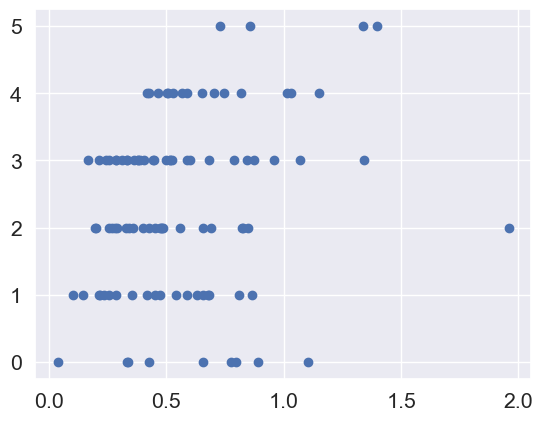

In [147]:
plt.scatter(frequence_kak, label, label='Data Points')
plt.show()

[[0 2 3 2 2 1]
 [5 2 2 1 5 4]
 [8 3 2 5 4 1]
 [4 6 7 1 9 2]
 [5 1 1 3 2 3]
 [0 0 0 2 0 2]]


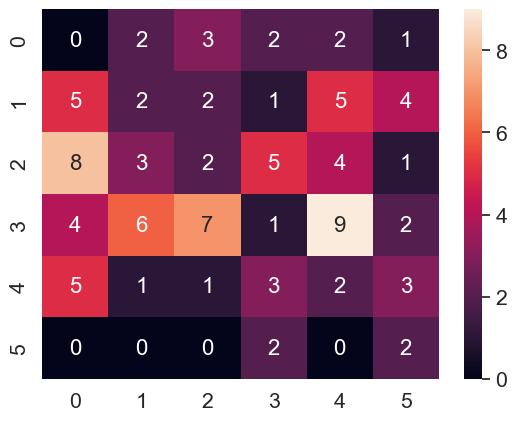

In [149]:
#ALEATOIRE

estimation_aleatoire = [np.random.randint(0,6) for i in range(len(label))]

#matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm=confusion_matrix(label,estimation_aleatoire)
print(cm)
df_cm = pd.DataFrame(cm, range(6), range(6))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [150]:
def min_max_normalization(data):
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
    return np.array(normalized_data)

ValueError: x and y must be the same size

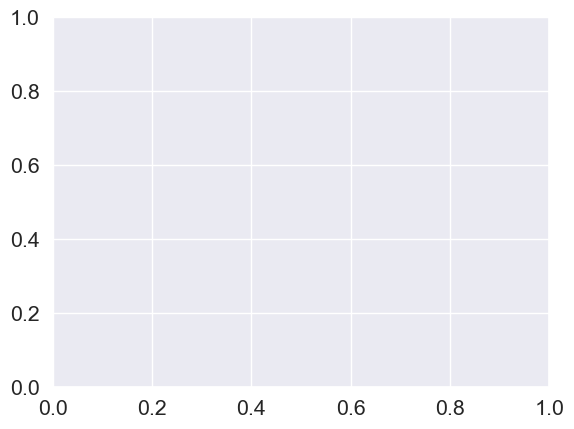

In [186]:
#METHODE 1

frequence_kak_int = [int(5/max(frequence_kak)*freq) for freq in np.nan_to_num(frequence_kak)][50:]
plt.scatter(frequence_kak_int, label, label='Data Points', alpha=0.5)


In [152]:
# NORMALISATION ET RMSE

normalized_predicted = min_max_normalization(frequence_kak_int)
normalized_actual = min_max_normalization(label)
normalized_aleatoire = min_max_normalization(estimation_aleatoire)

rmse_model = np.sqrt(np.mean((normalized_predicted - normalized_actual)**2))
rmse_aleatoire = np.sqrt(np.mean((normalized_aleatoire - normalized_actual)**2))

# Print the RMSE
print("RMSE du modèle:", rmse_model)
print("RMSE de l'estimation aléatoire:", rmse_aleatoire)

RMSE du modèle: 0.39496835316262996
RMSE de l'estimation aléatoire: 0.4312771730569565


In [153]:
percentage_difference = (abs(rmse_model - rmse_aleatoire) / rmse_model) * 100

print("Pourcentage de différence entre les deux RMSE:", percentage_difference)

Pourcentage de différence entre les deux RMSE: 9.192842819833778


[[3 2 2 0 0 0]
 [3 2 1 0 0 0]
 [5 5 2 0 0 1]
 [2 7 2 1 0 0]
 [0 7 3 0 0 0]
 [0 1 1 0 0 0]]


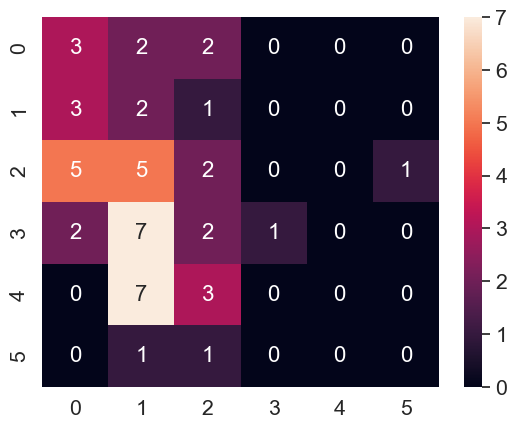

In [187]:
#matrice de confusion METHODE 1
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm=confusion_matrix(label[50:],frequence_kak_int)
print(cm)
df_cm = pd.DataFrame(cm, range(6), range(6))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [155]:
def r_squared(y_true, y_pred):
    # Moyenne des valeurs observées
    y_mean = np.mean(y_true)
    
    # Somme des carrés totaux
    ss_total = np.sum((y_true - y_mean) ** 2)
    
    # Somme des carrés résiduels (erreurs)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    
    # Coefficient de détermination R²
    r_squared = 1 - (ss_residual / ss_total)
    
    return r_squared

In [156]:
r_squared_value = r_squared(normalized_actual, normalized_predicted)
print("Coefficient de détermination R²:", r_squared_value)

r_squared_value = r_squared(normalized_actual, normalized_aleatoire)
print("Coefficient de détermination R²:", r_squared_value)

Coefficient de détermination R²: -1.2444751381215475
Coefficient de détermination R²: -1.6761049723756916


In [157]:
#METHODE 2

#random forest sur [nombre, frequence, moyenne, std]
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Supposons que vous ayez vos données dans une liste appelée "data" où chaque élément est une liste de caractéristiques [nombre_train, fréquence, moyenne, std]
data = [[compte_kak[i],frequence_kak[i],moyenne_longueur[i],variance_longueur[i]] for i in range(len(frequence_kak))]

# Convertir les listes en tableaux numpy
X = np.array(data)
y = np.array(label)

In [158]:
print(X)

[[1.23000000e+02 2.13430999e-01 6.37398374e+00 5.59383862e+00]
 [3.10000000e+01 1.01002641e-01 5.12903226e+00 4.32354347e+00]
 [2.67000000e+02 2.70083928e-01 6.14981273e+00 5.01533509e+00]
 [5.56000000e+02 5.21959865e-01 5.25719424e+00 3.05413425e+00]
 [1.81400000e+03 8.73437049e-01 6.17420066e+00 4.47773818e+00]
 [6.40000000e+01 2.55558395e-01 6.14062500e+00 3.77850494e+00]
 [5.70000000e+02 3.79476378e-01 6.32280702e+00 4.55850920e+00]
 [2.03000000e+02 4.42648974e-01 7.08374384e+00 5.11039526e+00]
 [2.37400000e+03 1.39647412e+00 7.86815501e+00 5.99233337e+00]
 [1.42000000e+02 8.66586382e-01 8.14084507e+00 5.73547344e+00]
 [1.24000000e+02 2.85724819e-01 7.63709677e+00 7.76814699e+00]
 [1.48000000e+02 9.59278208e-01 8.83108108e+00 7.10670459e+00]
 [5.80000000e+01 2.41559307e-01 6.32758621e+00 4.88272087e+00]
 [8.30000000e+01 4.23861532e-01 6.44578313e+00 5.27840112e+00]
 [1.20000000e+02 2.83804238e-01 6.54166667e+00 5.07755819e+00]
 [7.02000000e+02 1.33607739e+00 7.60541311e+00 5.312686

In [159]:
import numpy as np

X = np.nan_to_num(X, nan=0)
print(X)

[[1.23000000e+02 2.13430999e-01 6.37398374e+00 5.59383862e+00]
 [3.10000000e+01 1.01002641e-01 5.12903226e+00 4.32354347e+00]
 [2.67000000e+02 2.70083928e-01 6.14981273e+00 5.01533509e+00]
 [5.56000000e+02 5.21959865e-01 5.25719424e+00 3.05413425e+00]
 [1.81400000e+03 8.73437049e-01 6.17420066e+00 4.47773818e+00]
 [6.40000000e+01 2.55558395e-01 6.14062500e+00 3.77850494e+00]
 [5.70000000e+02 3.79476378e-01 6.32280702e+00 4.55850920e+00]
 [2.03000000e+02 4.42648974e-01 7.08374384e+00 5.11039526e+00]
 [2.37400000e+03 1.39647412e+00 7.86815501e+00 5.99233337e+00]
 [1.42000000e+02 8.66586382e-01 8.14084507e+00 5.73547344e+00]
 [1.24000000e+02 2.85724819e-01 7.63709677e+00 7.76814699e+00]
 [1.48000000e+02 9.59278208e-01 8.83108108e+00 7.10670459e+00]
 [5.80000000e+01 2.41559307e-01 6.32758621e+00 4.88272087e+00]
 [8.30000000e+01 4.23861532e-01 6.44578313e+00 5.27840112e+00]
 [1.20000000e+02 2.83804238e-01 6.54166667e+00 5.07755819e+00]
 [7.02000000e+02 1.33607739e+00 7.60541311e+00 5.312686

In [190]:
# Diviser les données en ensembles d'entraînement et de test (50% train, 50% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

        # Initialiser et entraîner le modèle de forêt aléatoire
rf_classifier = RandomForestClassifier(n_estimators=10000, random_state=42)
rf_classifier.fit(X_train, y_train)

        # Faire des prédictions sur l'ensemble de test
y_pred = rf_classifier.predict(X_test)

        # Calculer l'exactitude (accuracy) des prédictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy random forest :", accuracy)

Accuracy random forest : 0.34


[[0 3 1 1 2 0]
 [0 3 3 2 1 0]
 [0 3 3 3 0 1]
 [0 2 2 8 2 1]
 [0 2 0 4 2 0]
 [0 0 0 0 0 1]]


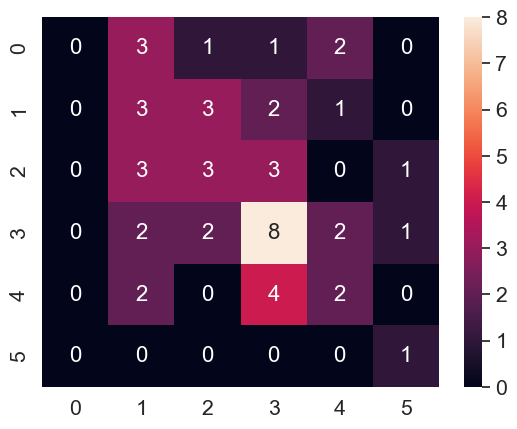

In [191]:
#matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm=confusion_matrix(y_test,y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(6), range(6))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

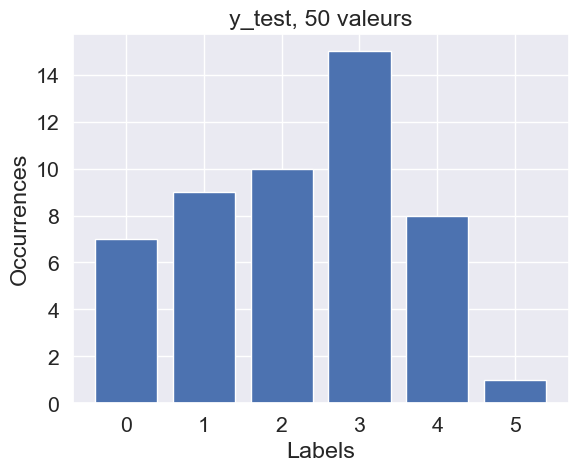

In [192]:
import matplotlib.pyplot as plt
from collections import Counter

occurrences = Counter(y_test)

# Récupérez les labels et les occurrences sous forme de listes
labels = list(occurrences.keys())
occurrences = list(occurrences.values())

# Créez l'histogramme
plt.bar(labels, occurrences)

# Ajoutez des labels aux axes
plt.xlabel('Labels')
plt.ylabel('Occurrences')
plt.title(f'y_test, {len(y_test)} valeurs')

# Affichez l'histogramme
plt.show()

In [183]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, frequence_kak_int[-len(y_test):])
print("Accuracy fréquence :", accuracy)

precision = precision_score(y_test, frequence_kak_int[-len(y_test):], average='macro')
recall = recall_score(y_test, frequence_kak_int[-len(y_test):], average='macro')
f1_score = f1_score(y_test, frequence_kak_int[-len(y_test):], average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy fréquence : 0.12
Precision: 0.215472027972028
Recall: 0.10714285714285714
F1 Score: 0.08367604617604618


c:\miniconda\envs\pynum\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [181]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, estimation_aleatoire[-len(y_test):])
print("Accuracy aléatoire :", accuracy)

precision = precision_score(y_test, estimation_aleatoire[-len(y_test):], average='macro')
recall = recall_score(y_test, estimation_aleatoire[-len(y_test):], average='macro')
f1_score = f1_score(y_test, estimation_aleatoire[-len(y_test):], average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy aléatoire : 0.18
Precision: 0.18208874458874458
Recall: 0.1652116402116402
F1 Score: 0.1675693988387487


In [193]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.2712657712657712
Recall: 0.40277777777777773
F1 Score: 0.3066719829877725


c:\miniconda\envs\pynum\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0 0 2 1 0 0]
 [0 1 1 3 0 0]
 [1 1 2 1 0 1]
 [0 0 3 5 2 0]
 [0 1 1 2 1 0]
 [0 0 1 0 0 0]]


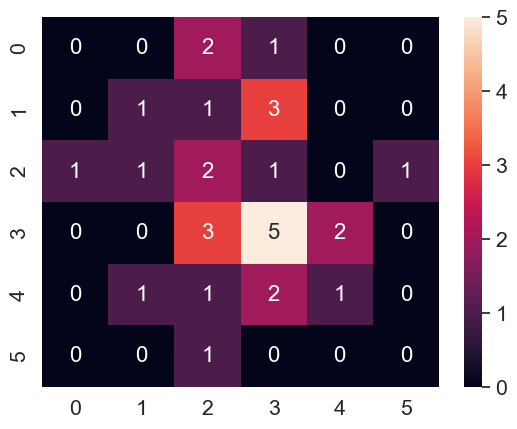

In [166]:
#matrice de confusion METHODE 2
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm=confusion_matrix(y_test,y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(6), range(6))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

-------